In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
import librosa

# ==== 1. Загрузка и парсинг TFRecord файлов ====

In [2]:
train_files = ["nsynth-train.tfrecord"]
valid_files = ["nsynth-valid.tfrecord"]
test_files = ["nsynth-test.tfrecord"]

In [3]:
class_counts = {
    0: 68955, 1: 13830, 2: 9423, 3: 35423, 4: 54991, 
    5: 35066, 6: 36577, 7: 14866, 8: 20594, 9: 5501, 10: 10753
}

In [4]:
def load_dataset(files):
    dataset = tf.data.TFRecordDataset(files)
    feature_description = {
        "audio": tf.io.FixedLenFeature([64000], tf.float32),
        "instrument_family": tf.io.FixedLenFeature([], tf.int64),
    }
    def parse_tfrecord(example):
        example = tf.io.parse_single_example(example, feature_description)
        return example["audio"], example["instrument_family"]

    return dataset.map(parse_tfrecord)

In [8]:
def pad_or_trim_audio(audio, target_length=64000):
    audio_length = tf.shape(audio)[0]
    if audio_length < target_length:
        padding = target_length - audio_length
        audio = tf.pad(audio, [[0, padding]])
    else:
        audio = audio[:target_length]
    return audio

# ==== 2. Преобразование аудио в Mel-спектрограммы ====

In [6]:
def augment_audio(audio):
    audio = audio + tf.random.normal(shape=tf.shape(audio), mean=0.0, stddev=0.005)
    audio = tf.image.random_crop(audio, size=(64000,))
    return audio

In [11]:
def audio_to_mel_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrogram = tf.abs(spectrogram)
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=64, num_spectrogram_bins=tf.shape(spectrogram)[-1], sample_rate=16000
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_filterbank, axes=1)
    mel_spectrogram.set_shape([None, 64])
    return tf.math.log(mel_spectrogram + 1e-6)

In [3]:
def load_audio_file(audio_file, sr=16000):
    audio, _ = librosa.load(audio_file, sr=sr)
    return tf.convert_to_tensor(audio, dtype=tf.float32)

def process_audio_to_mel(audio):
    audio = pad_or_trim_audio(audio)
    return audio_to_mel_spectrogram(audio)

def resize_spectrogram(spectrogram, target_size=(224, 224)):
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, target_size)
    return tf.image.grayscale_to_rgb(spectrogram)

def prepare_mel_spectrogram(audio, target_size=(224, 224)):
    spectrogram = process_audio_to_mel(audio)
    return resize_spectrogram(spectrogram, target_size)

In [ ]:
def preprocess_dataset_for_pretrained(dataset, augment=False, batch_size=32):
    def process_example(audio, label):
        audio = pad_or_trim_audio(audio)
        if augment:
            audio = augment_audio(audio)
        mel_spectrogram = prepare_mel_spectrogram(audio, target_size=(224, 224))  
        return mel_spectrogram, label

    return dataset.map(process_example, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ==== 3. Создание модели ====

In [9]:
def create_pretrained_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False  

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ==== 4. Настройка коллбеков ====

In [18]:
train_samples = 289206  
valid_samples = 12678   

In [19]:
batch_size = 16
steps_per_epoch = train_samples // batch_size + (1 if train_samples % batch_size != 0 else 0)
validation_steps = valid_samples // batch_size + (1 if valid_samples % batch_size != 0 else 0)

In [20]:
train_dataset = preprocess_dataset_for_pretrained(load_dataset(train_files), augment=True, batch_size=batch_size)
valid_dataset = preprocess_dataset_for_pretrained(load_dataset(valid_files), augment=False, batch_size=batch_size)

In [21]:
input_shape = (224, 224, 3)
num_classes = len(class_counts)
model = create_pretrained_model(input_shape, num_classes)

In [22]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [23]:
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Train dataset length: {train_samples}")
print(f"Validation dataset length: {valid_samples}")

Steps per epoch: 36151
Validation steps: 1585
Train dataset length: 289206
Validation dataset length: 12678


# ==== 5. Обучение модели ====

In [25]:
steps_per_epoch = 10000

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight={class_id: train_samples / (len(class_counts) * count) for class_id, count in class_counts.items()},
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/5


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1183s 118ms/step - accuracy: 0.9142 - loss: 0.2656 - val_accuracy: 0.1641 - val_loss: 18.4578 - learning_rate: 1.0000e-04
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1093s 109ms/step - accuracy: 0.8980 - loss: 0.6612 - val_accuracy: 0.0024 - val_loss: 5.5672 - learning_rate: 1.0000e-04
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1096s 110ms/step - accuracy: 0.3302 - loss: 2.9522 - val_accuracy: 0.1896 - val_loss: 3.2349 - learning_rate: 1.0000e-04
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1097s 110ms/step - accuracy: 0.7024 - loss: 1.0761 - val_accuracy: 0.2082 - val_loss: 14.2198 - learning_rate: 1.0000e-04
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1102s 110ms/step - accuracy: 0.8753 - loss: 0.6174 - val_accuracy: 0.0555 - val_loss: 11.1066 - learning_rate: 1.0000e-04


In [26]:
model.layers[0].trainable = True 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:
history_fine_tune = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1321s 131ms/step - accuracy: 0.1223 - loss: 3.8750 - val_accuracy: 0.1465 - val_loss: 3.0038 - learning_rate: 1.0000e-05
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1282s 128ms/step - accuracy: 0.4810 - loss: 1.5803 - val_accuracy: 0.1836 - val_loss: 2.8686 - learning_rate: 1.0000e-05
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1284s 128ms/step - accuracy: 0.2885 - loss: 2.7531 - val_accuracy: 0.1887 - val_loss: 2.4465 - learning_rate: 1.0000e-05
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1322s 132ms/step - accuracy: 0.4751 - loss: 1.6071 - val_accuracy: 0.2082 - val_loss: 3.5541 - learning_rate: 1.0000e-05
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1510s 151ms/step - accuracy: 0.7650 - loss: 0.9333 - val_accuracy: 0.1261 - val_loss: 3.7204 - learning_rate: 1.0000e-05


# ==== 6. Визуализация результатов ====


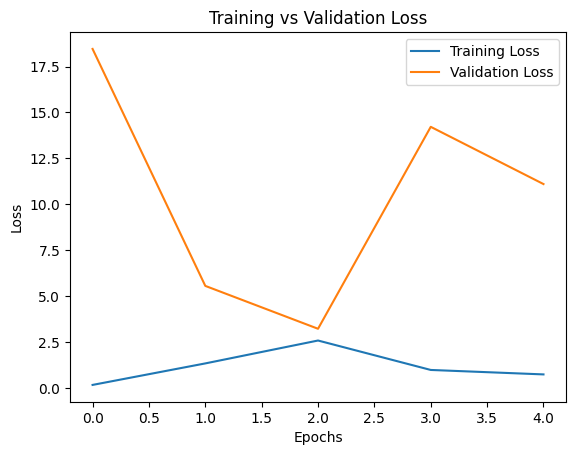

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

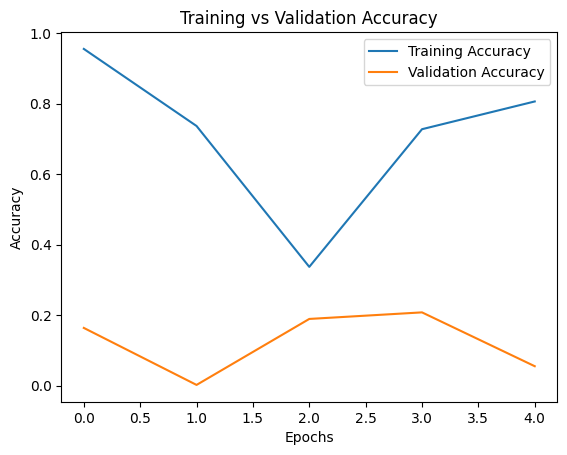

In [29]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# ==== 7. Предсказание для новых данных ====

In [ ]:
import librosa

def predict_example(audio_file):
    audio, sr = librosa.load(audio_file, sr=16000)
    audio = tf.convert_to_tensor(pad_or_trim_audio(audio))
    
    mel_spectrogram = prepare_mel_spectrogram(audio, target_size=(224, 224))

    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=0)
    
    prediction = model.predict(mel_spectrogram, verbose=0)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    return predicted_label


In [13]:
predicted_label = predict_example(r"C:\Users\dperv\Desktop\Проектный практикум\vocal.wav")
print(f"Predicted Instrument Family: {predicted_label}")

NameError: name 'model' is not defined